In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import os
import cv2
import wandb
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score

# Initialize wandb
wandb.init(project="model-b-classifier", config={
    "img_width": 128,
    "img_height": 128,
    "batch_size": 32,
    "epochs": 100,
    "learning_rate": 0.001,
    "architecture": "VGG16",
})

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: dnicho26 (dnicho26-university-of-north-carolina-at-charlotte). Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.18.5


wandb: Run data is saved locally in /opt/notebooks/Applied-AI-Midterm/wandb/run-20241102_140614-dt8zgymn
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run youthful-universe-18


wandb: ⭐️ View project at https://wandb.ai/dnicho26-university-of-north-carolina-at-charlotte/model-b-classifier


wandb: 🚀 View run at https://wandb.ai/dnicho26-university-of-north-carolina-at-charlotte/model-b-classifier/runs/dt8zgymn


In [2]:
# Configuration
config = wandb.config
data_dir = r'/opt/notebooks/Applied-AI-Midterm/Data/srgan-images/train'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(torch.cuda.get_device_name(cuda_id))

True
Tesla P100-PCIE-16GB


In [3]:
# Custom Dataset to handle your directory structure
class CustomImageDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        image = Image.open(img_path).convert("RGB")
        
        label = 0 if 'cat' in img_path else 1
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [4]:
# Gathering all image paths
all_images = [os.path.join(data_dir, img) for img in os.listdir(data_dir)]
train_size = int(0.8 * len(all_images))
valid_size = len(all_images) - train_size

# Splitting the dataset into training and validation sets
train_images, valid_images = torch.utils.data.random_split(all_images, [train_size, valid_size])

# Data transformation and augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((config.img_width, config.img_height)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(90),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((config.img_width, config.img_height)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Creating datasets and loaders
train_dataset = CustomImageDataset(train_images, transform=data_transforms['train'])
valid_dataset = CustomImageDataset(valid_images, transform=data_transforms['valid'])

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].


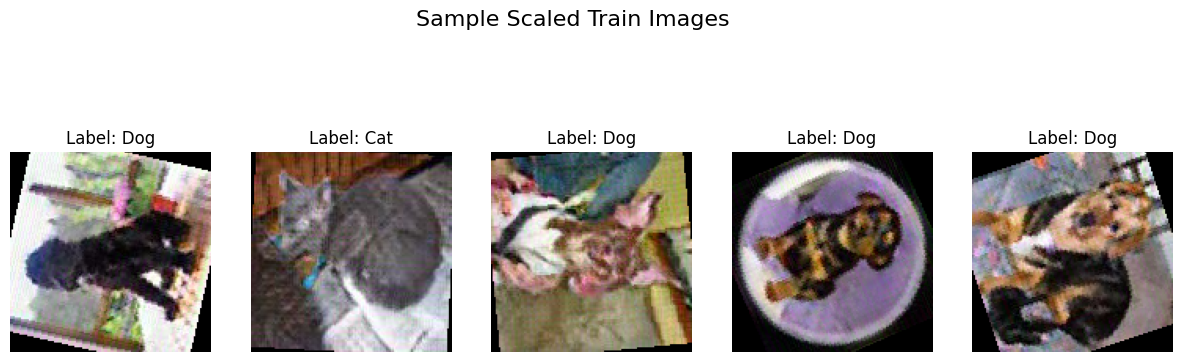

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9921568508148193].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.7418136649970393e-09..1.0000000236034394].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3.051757813121725e-08..1.0000000236034394].


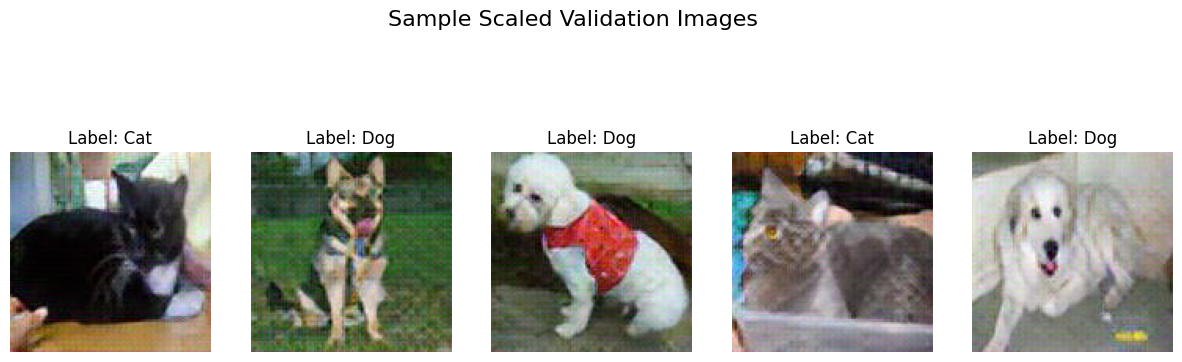

In [5]:
import matplotlib.pyplot as plt

def show_images_from_loader(loader, title):
    # Fetch a batch of images
    images, labels = next(iter(loader))
    images = images.numpy().transpose((0, 2, 3, 1))
    fig, axs = plt.subplots(1, 5, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)

    for i, ax in enumerate(axs):
        ax.imshow(images[i] * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])
        ax.set_title(f'Label: {"Cat" if labels[i] == 0 else "Dog"}')
        ax.axis('off')

    plt.show()

# Display some train images
show_images_from_loader(train_loader, "Sample Scaled Train Images")

# Display some validation images
show_images_from_loader(valid_loader, "Sample Scaled Validation Images")

In [6]:
# Load pretrained VGG16 model
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096, 2)  # Modify the output layer to match the number of classes

# Freeze layers except the last few
for param in model.features.parameters():
    param.requires_grad = False

model = model.to(device)

# Define loss function and optimizer
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=[0 if 'cat' in img else 1 for img in all_images])
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

/opt/conda/envs/applied-ai/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/applied-ai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
import os

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.best_val_loss = float('inf')

    def __call__(self, val_loss, model, path):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.best_val_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path)
        self.best_val_loss = val_loss


In [8]:
from tqdm import tqdm
# Initialize metrics dictionary
metrics = {
    'train_losses': [], 'val_losses': [],
    'train_accuracies': [], 'val_accuracies': [],
    'train_f1s': [], 'val_f1s': [],
    'train_aucs': [], 'val_aucs': []
}

# Define the training function
def train_model(model, criterion, optimizer, train_loader, valid_loader, epochs, metrics, patience=5, model_dir='model_checkpoints', model_name='best_model-a.pth'):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    
    best_val_loss = float('inf')
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    print("Starting training loop...")

    for epoch in range(epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0
        all_labels, all_preds = [], []
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
        
        # Calculate and store metrics
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        epoch_f1 = f1_score(all_labels, all_preds, average="macro")
        epoch_auc = roc_auc_score(all_labels, np.array(all_preds), multi_class='ovr')
        metrics['train_losses'].append(epoch_loss)
        metrics['train_accuracies'].append(epoch_acc.item())
        metrics['train_f1s'].append(epoch_f1)
        metrics['train_aucs'].append(epoch_auc)

        # Validation phase
        model.eval()
        val_loss, val_corrects = 0.0, 0
        all_labels, all_preds = [], []
        
        with torch.no_grad():
            for inputs, labels in tqdm(valid_loader, desc=f"Validation Epoch {epoch+1}/{epochs}", unit="batch"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        # Calculate and store validation metrics
        val_loss /= len(valid_loader.dataset)
        val_acc = val_corrects.double() / len(valid_loader.dataset)
        val_f1 = f1_score(all_labels, all_preds, average="macro")
        val_auc = roc_auc_score(all_labels, np.array(all_preds), multi_class='ovr')
        metrics['val_losses'].append(val_loss)
        metrics['val_accuracies'].append(val_acc.item())
        metrics['val_f1s'].append(val_f1)
        metrics['val_aucs'].append(val_auc)

        # Log to wandb
        wandb.log({"epoch": epoch, "train_loss": epoch_loss, "train_accuracy": epoch_acc, "train_f1": epoch_f1, "train_auc": epoch_auc,
                   "val_loss": val_loss, "val_accuracy": val_acc, "val_f1": val_f1, "val_auc": val_auc})

        print(f"Epoch {epoch+1}/{epochs}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(model_dir, model_name)
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with val_loss: {best_val_loss:.4f} at {best_model_path}")

        # Early stopping
        early_stopping(val_loss, model, best_model_path)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

In [9]:
epochs = wandb.config.epochs
# Train the model and update metrics dictionary
train_model(model, criterion, optimizer, train_loader, valid_loader, epochs, metrics)

# Finish the wandb run
wandb.finish()

Starting training loop...


Epoch 1/100:   0%|                                                                                                                                          | 0/625 [00:00<?, ?batch/s]

Epoch 1/100:   0%|▏                                                                                                                                 | 1/625 [00:01<20:00,  1.92s/batch]

Epoch 1/100:   0%|▍                                                                                                                                 | 2/625 [00:03<18:25,  1.77s/batch]

Epoch 1/100:   0%|▌                                                                                                                                 | 3/625 [00:04<15:31,  1.50s/batch]

Epoch 1/100:   1%|▊                                                                                                                                 | 4/625 [00:05<13:59,  1.35s/batch]

Epoch 1/100:   1%|█                                                                                                                                 | 5/625 [00:07<13:36,  1.32s/batch]

Epoch 1/100:   1%|█▏                                                                                                                                | 6/625 [00:09<15:56,  1.54s/batch]

Epoch 1/100:   1%|█▍                                                                                                                                | 7/625 [00:10<16:30,  1.60s/batch]

Epoch 1/100:   1%|█▋                                                                                                                                | 8/625 [00:12<17:46,  1.73s/batch]

Epoch 1/100:   1%|█▊                                                                                                                                | 9/625 [00:14<19:01,  1.85s/batch]

Epoch 1/100:   2%|██                                                                                                                               | 10/625 [00:17<19:50,  1.94s/batch]

Epoch 1/100:   2%|██▎                                                                                                                              | 11/625 [00:19<20:32,  2.01s/batch]

Epoch 1/100:   2%|██▍                                                                                                                              | 12/625 [00:21<21:28,  2.10s/batch]

Epoch 1/100:   2%|██▋                                                                                                                              | 13/625 [00:23<21:30,  2.11s/batch]

Epoch 1/100:   2%|██▉                                                                                                                              | 14/625 [00:25<21:36,  2.12s/batch]

Epoch 1/100:   2%|███                                                                                                                              | 15/625 [00:28<21:47,  2.14s/batch]

Epoch 1/100:   3%|███▎                                                                                                                             | 16/625 [00:30<22:19,  2.20s/batch]

Epoch 1/100:   3%|███▌                                                                                                                             | 17/625 [00:32<22:05,  2.18s/batch]

Epoch 1/100:   3%|███▋                                                                                                                             | 18/625 [00:34<21:42,  2.15s/batch]

Epoch 1/100:   3%|███▉                                                                                                                             | 19/625 [00:36<21:18,  2.11s/batch]

Epoch 1/100:   3%|████▏                                                                                                                            | 20/625 [00:38<21:27,  2.13s/batch]

Epoch 1/100:   3%|████▎                                                                                                                            | 21/625 [00:40<21:33,  2.14s/batch]

Epoch 1/100:   4%|████▌                                                                                                                            | 22/625 [00:43<22:03,  2.19s/batch]

Epoch 1/100:   4%|████▋                                                                                                                            | 23/625 [00:45<22:29,  2.24s/batch]

Epoch 1/100:   4%|████▉                                                                                                                            | 24/625 [00:47<22:18,  2.23s/batch]

Epoch 1/100:   4%|█████▏                                                                                                                           | 25/625 [00:49<22:03,  2.21s/batch]

Epoch 1/100:   4%|█████▎                                                                                                                           | 26/625 [00:51<21:25,  2.15s/batch]

Epoch 1/100:   4%|█████▌                                                                                                                           | 27/625 [00:54<21:33,  2.16s/batch]

Epoch 1/100:   4%|█████▊                                                                                                                           | 28/625 [00:56<21:25,  2.15s/batch]

Epoch 1/100:   5%|█████▉                                                                                                                           | 29/625 [00:58<21:09,  2.13s/batch]

Epoch 1/100:   5%|██████▏                                                                                                                          | 30/625 [01:00<21:17,  2.15s/batch]

Epoch 1/100:   5%|██████▍                                                                                                                          | 31/625 [01:02<21:13,  2.14s/batch]

Epoch 1/100:   5%|██████▌                                                                                                                          | 32/625 [01:04<21:07,  2.14s/batch]

Epoch 1/100:   5%|██████▊                                                                                                                          | 33/625 [01:07<21:44,  2.20s/batch]

Epoch 1/100:   5%|███████                                                                                                                          | 34/625 [01:09<21:51,  2.22s/batch]

Epoch 1/100:   6%|███████▏                                                                                                                         | 35/625 [01:11<21:41,  2.21s/batch]

Epoch 1/100:   6%|███████▍                                                                                                                         | 36/625 [01:13<21:32,  2.19s/batch]

Epoch 1/100:   6%|███████▋                                                                                                                         | 37/625 [01:16<21:37,  2.21s/batch]

Epoch 1/100:   6%|███████▊                                                                                                                         | 38/625 [01:18<21:05,  2.16s/batch]

Epoch 1/100:   6%|████████                                                                                                                         | 39/625 [01:20<20:58,  2.15s/batch]

Epoch 1/100:   6%|████████▎                                                                                                                        | 40/625 [01:22<21:11,  2.17s/batch]

Epoch 1/100:   7%|████████▍                                                                                                                        | 41/625 [01:24<20:54,  2.15s/batch]

Epoch 1/100:   7%|████████▋                                                                                                                        | 42/625 [01:26<20:38,  2.12s/batch]

Epoch 1/100:   7%|████████▉                                                                                                                        | 43/625 [01:28<20:25,  2.11s/batch]

Epoch 1/100:   7%|█████████                                                                                                                        | 44/625 [01:31<21:16,  2.20s/batch]

Epoch 1/100:   7%|█████████▎                                                                                                                       | 45/625 [01:33<21:12,  2.19s/batch]

Epoch 1/100:   7%|█████████▍                                                                                                                       | 46/625 [01:35<21:47,  2.26s/batch]

Epoch 1/100:   8%|█████████▋                                                                                                                       | 47/625 [01:37<21:45,  2.26s/batch]

Epoch 1/100:   8%|█████████▉                                                                                                                       | 48/625 [01:40<21:50,  2.27s/batch]

Epoch 1/100:   8%|██████████                                                                                                                       | 49/625 [01:42<21:40,  2.26s/batch]

Epoch 1/100:   8%|██████████▎                                                                                                                      | 50/625 [01:44<21:35,  2.25s/batch]

Epoch 1/100:   8%|██████████▌                                                                                                                      | 51/625 [01:46<21:42,  2.27s/batch]

Epoch 1/100:   8%|██████████▋                                                                                                                      | 52/625 [01:49<21:20,  2.23s/batch]

Epoch 1/100:   8%|██████████▉                                                                                                                      | 53/625 [01:51<21:41,  2.28s/batch]

Epoch 1/100:   9%|███████████▏                                                                                                                     | 54/625 [01:53<21:24,  2.25s/batch]

Epoch 1/100:   9%|███████████▎                                                                                                                     | 55/625 [01:55<21:15,  2.24s/batch]

Epoch 1/100:   9%|███████████▌                                                                                                                     | 56/625 [01:58<21:05,  2.22s/batch]

Epoch 1/100:   9%|███████████▊                                                                                                                     | 57/625 [02:00<21:36,  2.28s/batch]

Epoch 1/100:   9%|███████████▉                                                                                                                     | 58/625 [02:02<21:13,  2.25s/batch]

In [ ]:
def plot_and_save_figures(train_losses, val_losses, train_accuracies, val_accuracies, save_dir='/opt/notebooks/Applied-AI-Midterm/figs'):
    # Create directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'loss_plot.png'))
    plt.show()
    
    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'accuracy_plot.png'))
    plt.show()

# Call the function with collected metrics
plot_and_save_figures(train_losses, val_losses, train_accuracies, val_accuracies)
